In [1]:
import pandas as pd
import os
import sys

In [2]:
sys.path.append("../src/ga4_mlops/pipelines")

In [3]:
from data_preparation_utils import extract_column_names

In [4]:
df = pd.read_csv('../data/05_model_input/abt_test.csv')

In [5]:
_, _, _, target_col = extract_column_names(df)
target_col

'y_added_to_cart'

In [6]:
df[target_col].value_counts()

0    1920
1      80
Name: y_added_to_cart, dtype: int64

In [7]:
df.shape[0]

2000

In [8]:
df[target_col].value_counts() / df.shape[0]

0    0.96
1    0.04
Name: y_added_to_cart, dtype: float64

In [9]:
n_obs = 500
seed = 42

In [10]:
frac = n_obs / df.shape[0]

In [11]:
df_sample = df.groupby(target_col).apply(lambda x: x.sample(frac=frac, random_state=seed)).reset_index(drop=True)
df_sample

,i_full_visitor_id,i_visit_start_time,i_date,c_device_category_desktop,c_device_category_mobile,c_device_category_tablet,c_is_mobile_0,c_is_mobile_1,c_operating_system_Windows,c_operating_system_Web,...,c_is_first_visit_0,c_is_first_visit_1,n_product_pages_viewed,n_total_hits,n_total_pageviews,n_total_visits,n_total_time_on_site,y_added_to_cart,c_weekday,c_visit_start_hour
0,2.680467e+07,1.612036e+15,20210130,1,0,0,0,1,1,0,...,0,1,0.0,5.0,2.0,1.0,85.0,0,-1.0,13
1,6.983573e+07,1.612006e+15,20210130,1,0,0,0,1,0,1,...,1,0,0.0,30.0,13.0,2.0,17732.0,0,-1.0,2
2,5.552425e+09,1.611969e+15,20210130,1,0,0,0,1,0,1,...,0,1,0.0,9.0,3.0,1.0,63294.0,0,-1.0,8
3,2.087928e+07,1.611981e+15,20210130,1,0,0,0,1,0,1,...,0,1,0.0,5.0,2.0,1.0,14075.0,0,-1.0,24
4,1.477048e+07,1.612017e+15,20210130,1,0,0,0,1,0,1,...,0,1,0.0,5.0,2.0,1.0,61.0,0,-1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,5.521131e+07,1.612016e+15,20210130,0,1,0,1,0,0,0,...,1,0,1.0,99.0,31.0,1.0,42970.0,1,-1.0,1
496,3.872301e+06,1.611990e+15,20210130,0,1,0,1,0,0,1,...,0,1,1.0,19.0,6.0,1.0,23155.0,1,-1.0,6
497,7.747805e+07,1.612003e+15,20210130,1,0,0,0,1,0,1,...,1,0,1.0,194.0,49.0,1.0,74605.0,1,-1.0,5
498,8.227796e+07,1.611968e+15,20210130,1,0,0,0,1,0,1,...,0,1,1.0,116.0,35.0,3.0,39571.0,1,-1.0,16


In [12]:
df_sample[target_col].value_counts()

0    480
1     20
Name: y_added_to_cart, dtype: int64

In [13]:
df_sample.shape[0]

500

In [14]:
proportions = df_sample[target_col].value_counts() / df_sample.shape[0]
proportions

0    0.96
1    0.04
Name: y_added_to_cart, dtype: float64

In [15]:
proportions.to_string()

'0    0.96\n1    0.04'

---

In [16]:
import shap
import pandas as pd
import numpy as np
import xgboost as xgb
import pickle
sys.path.append("../src/ga4_mlops/pipelines")
from data_preparation_utils import extract_column_names

/Users/pchaberski/projects/gid-ml-framework/ga4-mlops/.venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [17]:
def sample_data(abt: pd.DataFrame, n_obs: int, seed: int) -> pd.DataFrame:
    """Sample model input data preserving target proportions.

    Args:
        abt (pd.DataFrame): input data frame
        n_obs (int): number of observations in a sample

    Returns:
        pd.DataFrame: data frame sample
    """
    original_n_obs = abt.shape[0]
    n_obs = max(1, min(n_obs, original_n_obs))
    # logger.info(
    #     f"Sampling data for SHAP explanations. Original size: {original_n_obs}; Sample size: {n_obs}"
    # )

    _, _, _, target_col = extract_column_names(abt)
    # logger.info(f"Target name: {target_col}")

    original_proportions = abt[target_col].value_counts() / original_n_obs
    # logger.info(f"Original target proportions:\n{original_proportions.to_string()}")

    frac = n_obs / original_n_obs
    abt_sample = (
        abt.groupby(target_col)
        .apply(lambda x: x.sample(frac=frac, random_state=seed))
        .reset_index(drop=True)
    )

    proportions = abt_sample[target_col].value_counts() / n_obs
    # logger.info(f"Sample target proportions:\n{proportions.to_string()}")

    return abt_sample

In [18]:
abt_train = pd.read_csv('../data/05_model_input/abt_train.csv')
abt = pd.read_csv('../data/05_model_input/abt_test.csv')

In [19]:
abt_train_sample = sample_data(abt_train, 100, 42)
abt_sample = sample_data(abt, 100, 42)

_, num_cols, cat_cols, _ = extract_column_names(abt_train_sample)

features_train_sample = abt_train_sample[num_cols + cat_cols]
features_sample = abt_sample[num_cols + cat_cols]

In [20]:
with open('../data/06_models/model.pkl', 'rb') as pickle_file:
    model = pickle.load(pickle_file)

In [21]:
explainer = shap.KernelExplainer(model.predict_proba, features_train_sample)

In [22]:
shap_values = explainer.shap_values(features_sample)

100%|██████████| 100/100 [00:47<00:00,  2.09it/s]


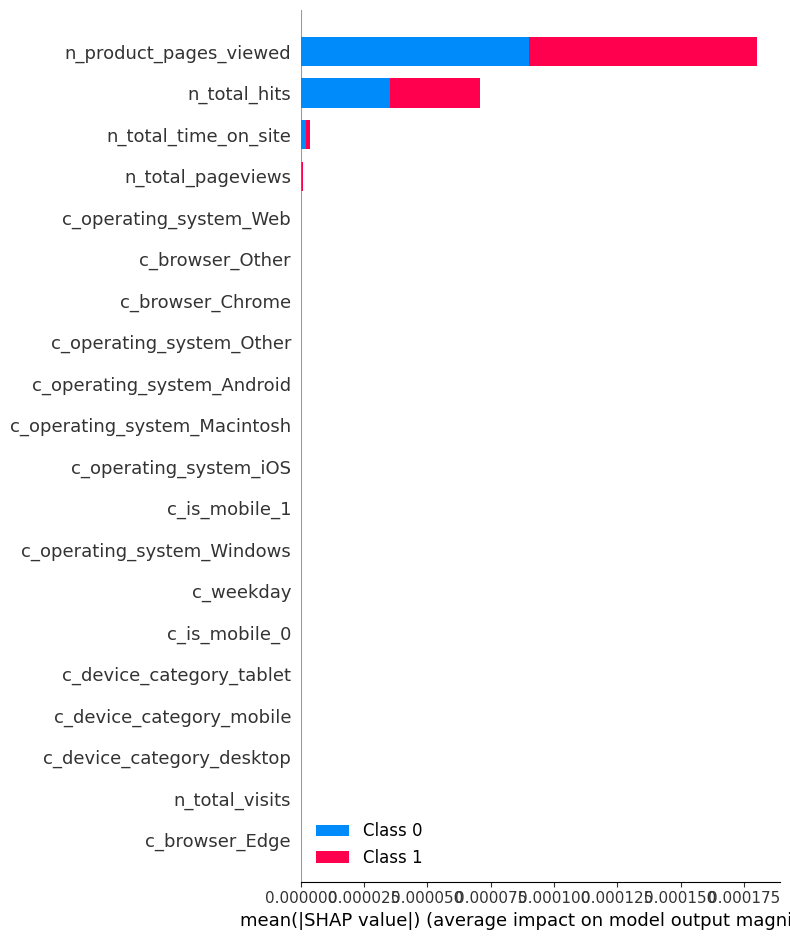

In [23]:
shap.summary_plot(shap_values, features=features_sample)

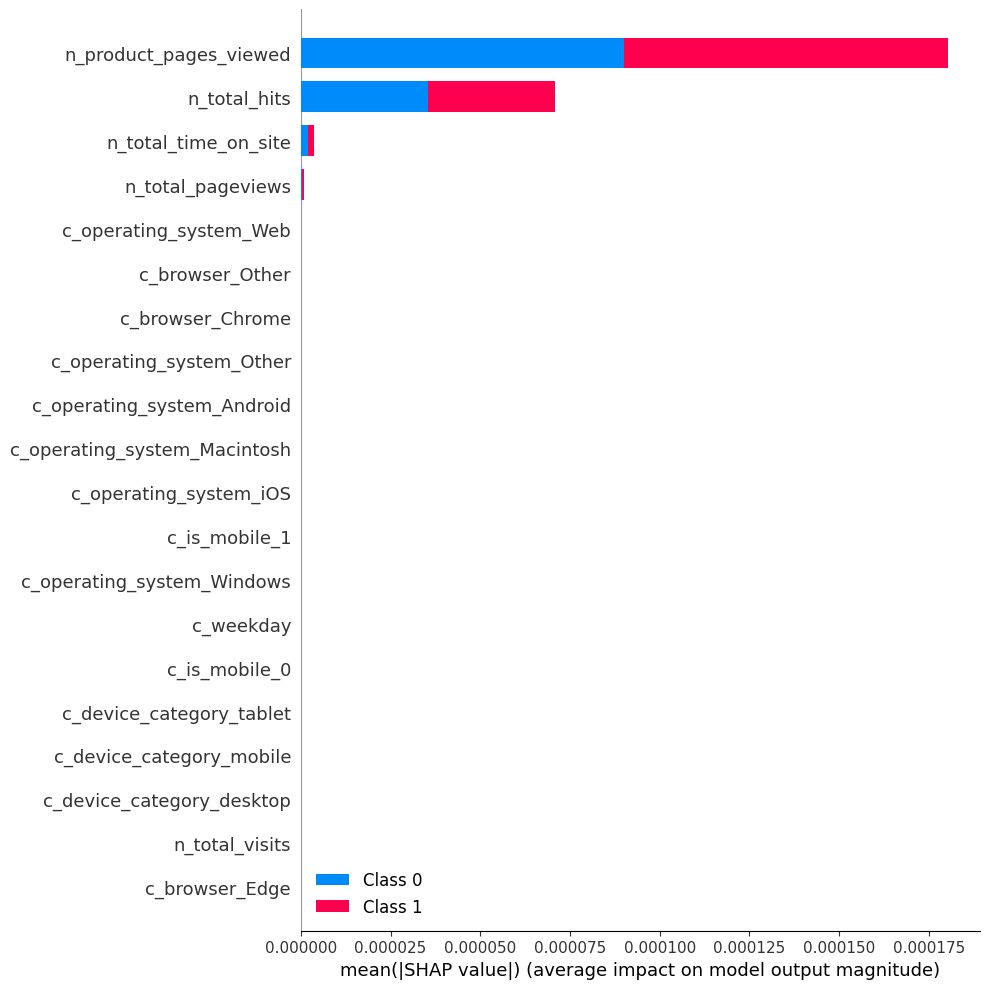

In [24]:
shap.summary_plot(shap_values, features=features_sample, plot_size=(10, 10))

In [25]:
features_sample.columns[np.argsort(np.abs(shap_values).mean(0))]

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.


array([['c_browser_Safari', 'c_country', 'c_city', ...,
        'c_operating_system_Windows', 'n_total_hits',
        'n_product_pages_viewed'],
       ['c_browser_Safari', 'c_country', 'c_city', ...,
        'c_browser_Other', 'c_weekday', 'n_product_pages_viewed'],
       ['c_browser_Safari', 'c_country', 'c_city', ...,
        'c_browser_Other', 'c_weekday', 'n_product_pages_viewed'],
       ...,
       ['c_browser_Safari', 'c_country', 'c_city', ...,
        'n_total_time_on_site', 'n_total_hits', 'n_product_pages_viewed'],
       ['c_browser_Safari', 'c_country', 'c_city', ...,
        'c_operating_system_Windows', 'n_total_hits',
        'n_product_pages_viewed'],
       ['c_browser_Safari', 'c_country', 'c_city', ...,
        'n_total_time_on_site', 'n_total_hits', 'n_product_pages_viewed']],
      dtype=object)

In [26]:
vals= np.abs(shap_values).mean(0)
feature_importance = pd.DataFrame(list(zip(features_sample.columns, sum(vals))), columns=['feature','importance'])
feature_importance.sort_values(by=['importance'], ascending=False, inplace=True)
feature_importance

,feature,importance
0,n_product_pages_viewed,0.009012
1,n_total_hits,0.003537
4,n_total_time_on_site,0.000189
2,n_total_pageviews,0.000044
30,c_traffic_medium_referral,0.000000
23,c_city,0.000000
24,c_traffic_source_google,0.000000
25,c_traffic_source_shop.googlemerchandisestore.com,0.000000
26,c_traffic_source_(direct),0.000000
27,c_traffic_source_Other,0.000000


In [27]:
# feature_importance = dict(zip(features_sample.columns, sum(vals)))
# feature_importance = dict(sorted(feature_importance.items(), key=lambda item: item[1], reverse=True))
# feature_importance

In [28]:
{k: v for k, v in zip(feature_importance["feature"], feature_importance["importance"])}

{'n_product_pages_viewed': 0.009012005303660517,
 'n_total_hits': 0.003537275631547897,
 'n_total_time_on_site': 0.00018892819306884665,
 'n_total_pageviews': 4.448705921407649e-05,
 'c_traffic_medium_referral': 0.0,
 'c_city': 0.0,
 'c_traffic_source_google': 0.0,
 'c_traffic_source_shop.googlemerchandisestore.com': 0.0,
 'c_traffic_source_(direct)': 0.0,
 'c_traffic_source_Other': 0.0,
 'c_traffic_source_(data deleted)': 0.0,
 'c_traffic_medium_organic': 0.0,
 'c_traffic_medium_(none)': 0.0,
 'c_weekday': 0.0,
 'c_country': 0.0,
 'c_traffic_medium_Other': 0.0,
 'c_traffic_medium_(data deleted)': 0.0,
 'c_traffic_campaign': 0.0,
 'c_is_first_visit_0': 0.0,
 'c_is_first_visit_1': 0.0,
 'c_traffic_medium_cpc': 0.0,
 'c_browser_Android Webview': 0.0,
 'c_browser_Firefox': 0.0,
 'c_browser_Safari': 0.0,
 'n_total_visits': 0.0,
 'c_device_category_desktop': 0.0,
 'c_device_category_mobile': 0.0,
 'c_device_category_tablet': 0.0,
 'c_is_mobile_0': 0.0,
 'c_is_mobile_1': 0.0,
 'c_operating_s

In [29]:
feature_importance.index[:5].to_list()

[0, 1, 4, 2, 30]

In [30]:
# top_5_features = feature_importance["feature"].head(5).to_list()
top_5_features = feature_importance.index[:5].to_list()
top_5_features

[0, 1, 4, 2, 30]

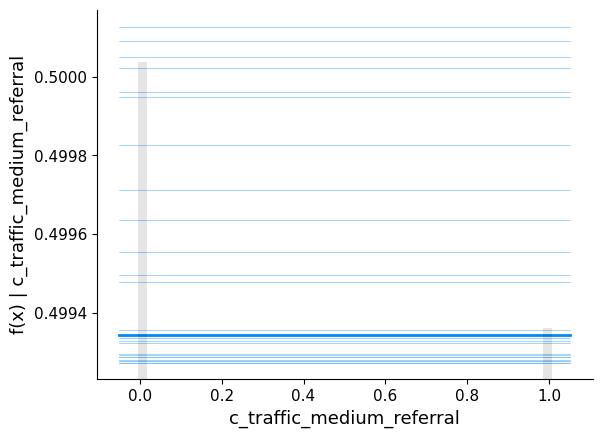

In [31]:
shap.plots.partial_dependence(30, lambda x: model.predict_proba(x)[:, 1], features_sample)

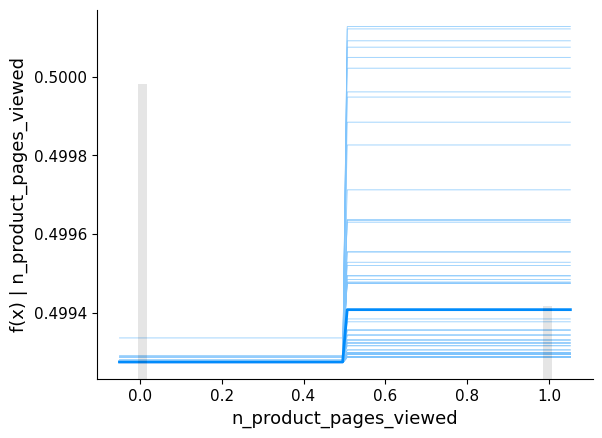

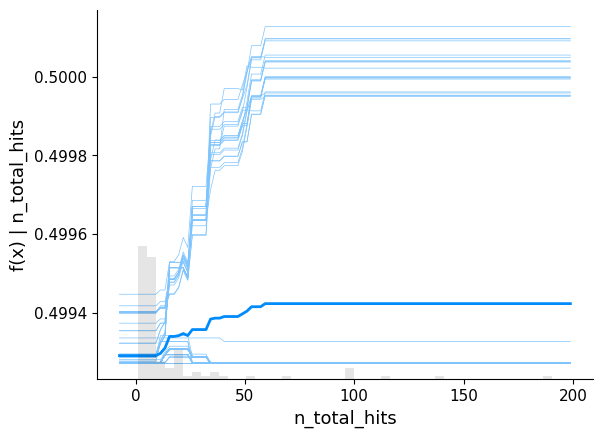

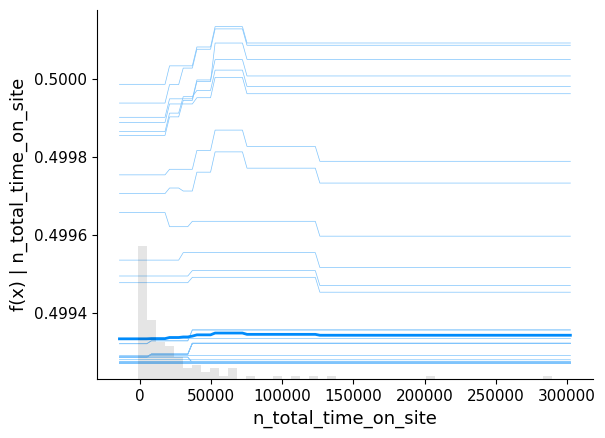

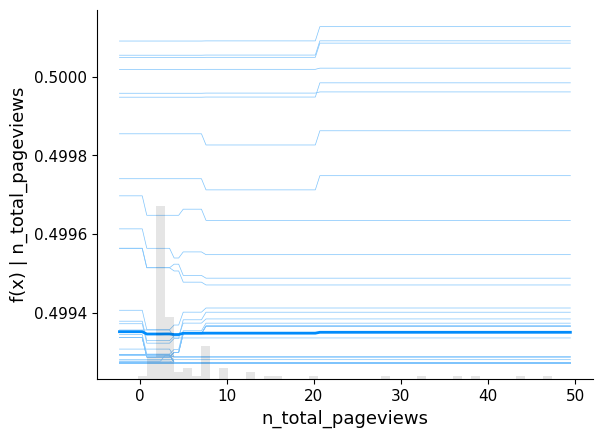

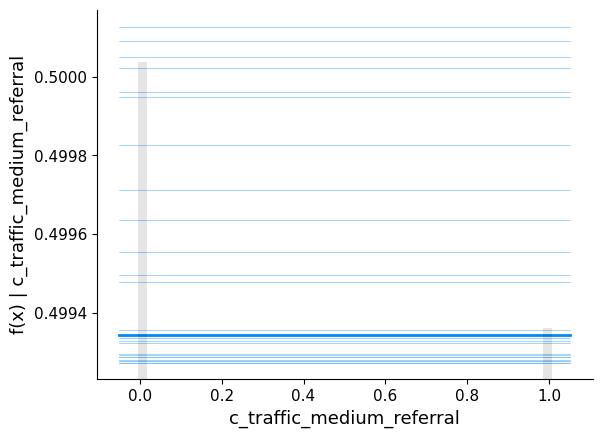

In [32]:
for idx in top_5_features:
    shap.plots.partial_dependence(idx, lambda x: model.predict_proba(x)[:, 1], features_sample)

In [33]:
type(shap_values)

list

---

In [34]:
import matplotlib.pyplot as plt
import io

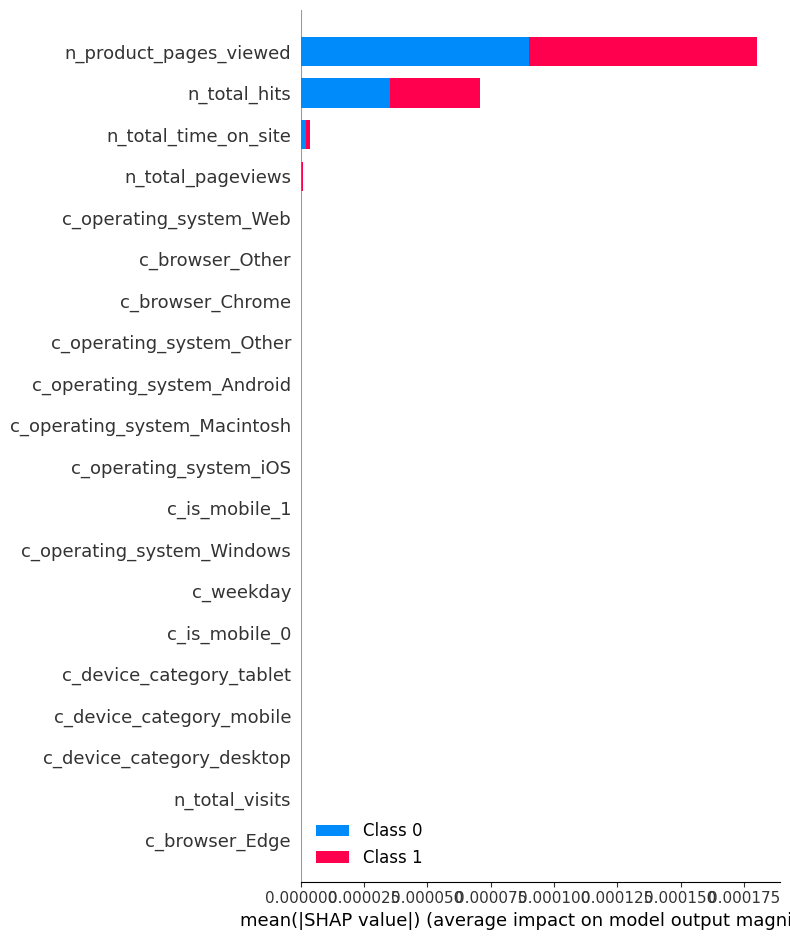

In [35]:
shap.summary_plot(
    shap_values,
    features=features_sample,
    show=False
)
fig = plt.gcf()
# plt.plot()

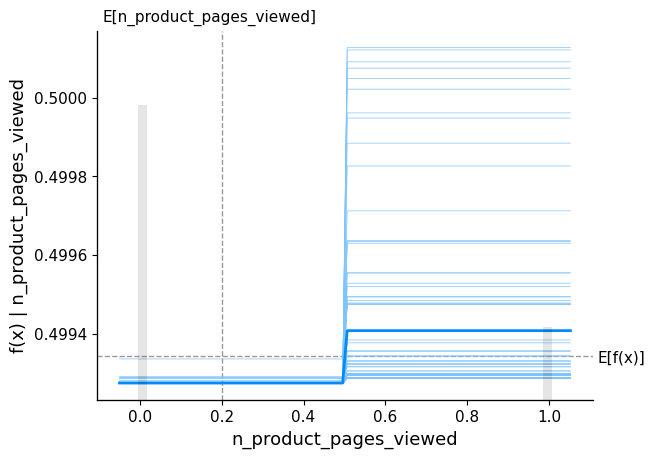

In [36]:
shap.plots.partial_dependence(
    0,
    lambda x: model.predict_proba(x)[:, 1],
    features_sample,
    model_expected_value=True,
    feature_expected_value=True,
    show=False
)
fig = plt.gcf()
# plt.plot()

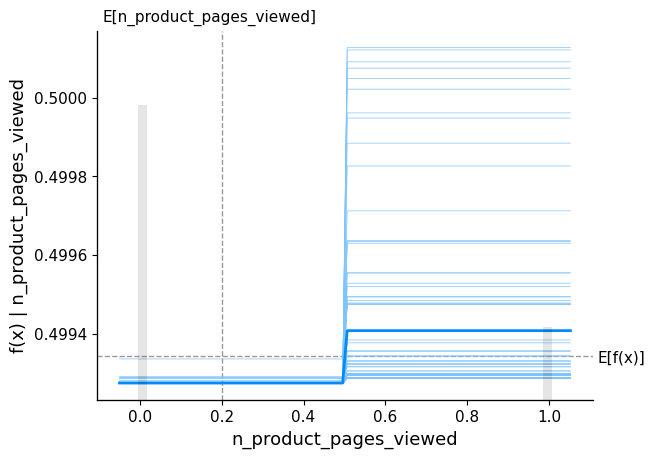

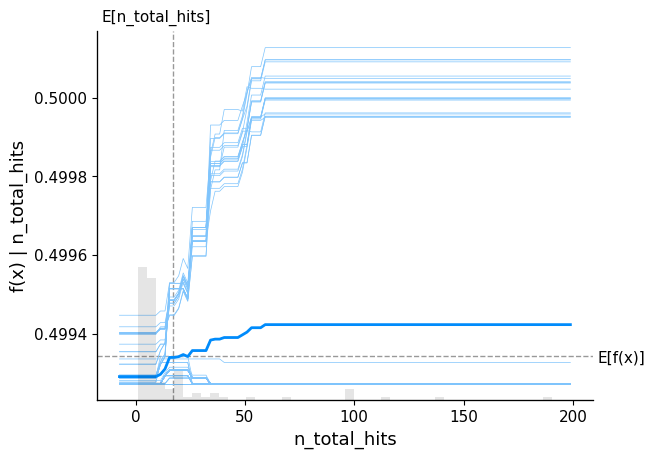

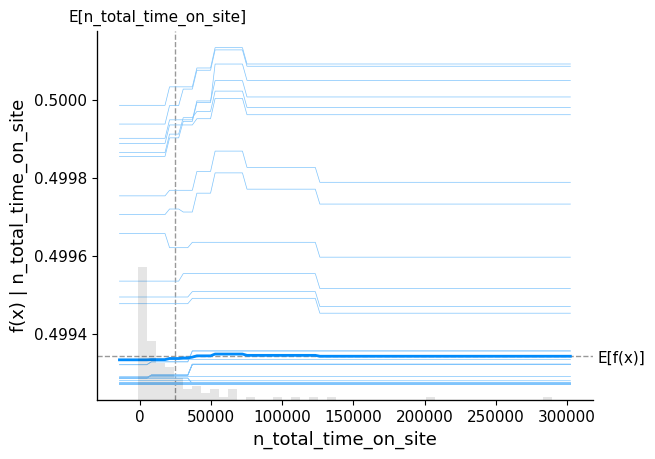

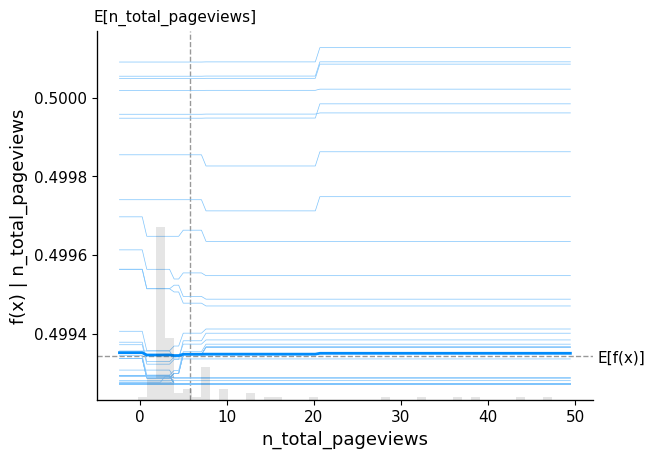

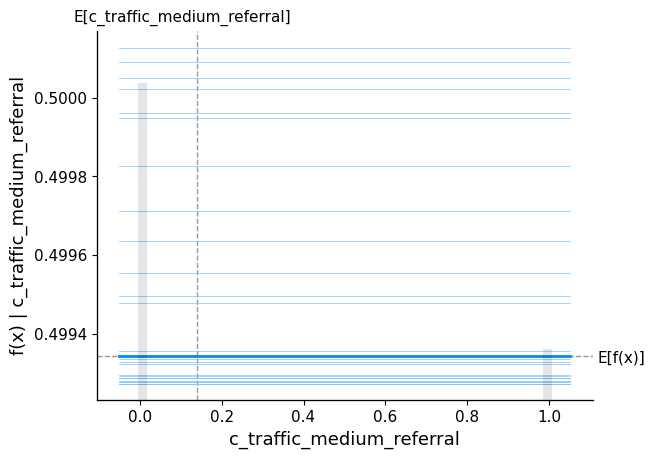

In [37]:
plots_dict = dict()
for idx in top_5_features:
    shap.plots.partial_dependence(
        idx,
        lambda x: model.predict_proba(x)[:, 1],
        features_sample,
        model_expected_value=True,
        feature_expected_value=True,
        show=False
    )
    feature_name = feature_importance["feature"][idx]
    plots_dict[f"{feature_name}.png"] = plt.gcf()
    # plt.plot()